In [1]:
#%% Importing modules and data
import smtplib
import pandas as pd
import numpy as np
import datetime as dt
# import pandas.stats.moments as st
import statsmodels.api as sm # import statsmodels 
from pandas import ExcelWriter
import matplotlib.pyplot as pyplot
import scipy.stats as st
import os
import quandl as qd
from collections import defaultdict
import seaborn as sns
# Import the Time Series library
import statsmodels.tsa.stattools as ts
%matplotlib inline

def save_xls(list_dfs, xls_path,sheet_names):
    writer = ExcelWriter(xls_path)
    for n, df in enumerate(list_dfs):
        df.to_excel(writer, sheet_names[n])
    writer.save()
    return


C:\Users\xexx\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Importing data from Quandl

btc = qd.get("BITFINEX/BTCUSD", authtoken="-ZxrLoLy3vKgLtLraaMn")
btc.columns = ['High','Low','Mid','Close','Bid','Ask','Volume']

eth = qd.get("BITFINEX/ETHUSD", authtoken="-ZxrLoLy3vKgLtLraaMn")
eth.columns = ['High','Low','Mid','Close','Bid','Ask','Volume']

ltc = qd.get("BITFINEX/LTCUSD", authtoken="-ZxrLoLy3vKgLtLraaMn")
ltc.columns = ['High','Low','Mid','Close','Bid','Ask','Volume']

neo = qd.get("BITFINEX/NEOUSD", authtoken="-ZxrLoLy3vKgLtLraaMn")
neo.columns = ['High','Low','Mid','Close','Bid','Ask','Volume']

etc = qd.get("BITFINEX/ETCUSD", authtoken="-ZxrLoLy3vKgLtLraaMn")
etc.columns = ['High','Low','Mid','Close','Bid','Ask','Volume']

rrt = qd.get("BITFINEX/RRTUSD", authtoken="-ZxrLoLy3vKgLtLraaMn")
rrt.columns = ['High','Low','Mid','Close','Bid','Ask','Volume']

xmr = qd.get("BITFINEX/XMRUSD", authtoken="-ZxrLoLy3vKgLtLraaMn")
xmr.columns = ['High','Low','Mid','Close','Bid','Ask','Volume']

zec = qd.get("BITFINEX/ZECUSD", authtoken="-ZxrLoLy3vKgLtLraaMn")
zec.columns = ['High','Low','Mid','Close','Bid','Ask','Volume']

omg = qd.get("BITFINEX/OMGUSD", authtoken="-ZxrLoLy3vKgLtLraaMn")
omg.columns = ['High','Low','Mid','Close','Bid','Ask','Volume']

In [3]:
omg.head(10)

,High,Low,Mid,Close,Bid,Ask,Volume
Date,,,,,,,
2017-07-14,0.85000,0.41100,0.561585,0.57339,0.55003,0.57314,3.002220e+05
2017-07-15,0.69820,0.42010,0.482205,0.46170,0.46312,0.50129,5.656600e+05
2017-07-16,0.52090,0.31500,0.393100,0.40389,0.38250,0.40370,1.114086e+06
2017-07-17,0.58800,0.37010,0.585160,0.58800,0.58232,0.58800,1.021973e+06
2017-07-18,0.89970,0.54630,0.718705,0.72680,0.70541,0.73200,1.921621e+06
2017-07-19,0.81210,0.55990,0.591695,0.57815,0.57830,0.60509,9.633149e+05
2017-07-20,0.73659,0.56000,0.682185,0.68879,0.67748,0.68689,8.523141e+05
2017-07-21,0.78510,0.62987,0.751310,0.74979,0.74906,0.75356,4.665221e+05
2017-07-22,0.85000,0.73490,0.826735,0.84000,0.81347,0.84000,1.032214e+06


In [4]:
window = 21
no_of_std = 2

rolling_mean = omg['Close'].rolling(window).mean()
rolling_std = omg['Close'].rolling(no_of_std).std()

omg['Rolling Mean'] = rolling_mean
omg['Bollinger High'] = rolling_mean + (rolling_std * no_of_std)
omg['Bollinger Low'] = rolling_mean - (rolling_std * no_of_std)

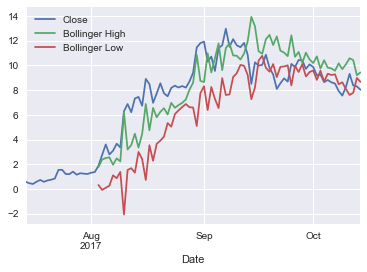

In [5]:
omg[['Close','Bollinger High','Bollinger Low']].plot()

C:\Users\xexx\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


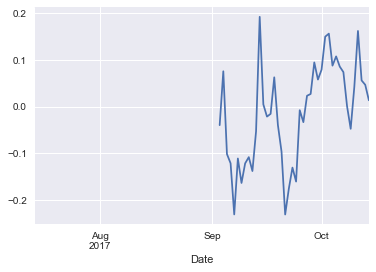

In [6]:
omg['Position'] = None

for row in range(len(omg)):
    if (omg['Close'].iloc[row] > omg['Bollinger High'].iloc[row]) and (omg['Close'].iloc[row-1] < omg['Bollinger High'].iloc[row-1]):
        omg['Position'].iloc[row] = -1

    if (omg['Close'].iloc[row] < omg['Bollinger Low'].iloc[row]) and (omg['Close'].iloc[row-1] > omg['Bollinger Low'].iloc[row-1]):
        omg['Position'].iloc[row] = 1  

#Forward fill our position column to replace the "None" values with the correct long/short positions to represent the "holding" of our position
#forward through time
omg['Position'].fillna(method='ffill',inplace=True)

#Calculate the daily market return and multiply that by the position to determine strategy returns
omg['Market Return'] = np.log(omg['Close'] / omg['Close'].shift(1))
omg['Strategy Return'] = omg['Market Return'] * omg['Position']

#Plot the strategy returns
omg['Strategy Return'].cumsum().plot()


In [7]:
omg.iloc[1]

High                    0.698200
Low                     0.420100
Mid                     0.482205
Close                   0.461700
Bid                     0.463120
Ask                     0.501290
Volume             565660.025531
Rolling Mean                 NaN
Bollinger High               NaN
Bollinger Low                NaN
Position                     NaN
Market Return          -0.216651
Strategy Return              NaN
Name: 2017-07-15 00:00:00, dtype: float64

In [8]:
def bollinger_strat(df,window,std):
    rolling_mean = df['Close'].rolling(window).mean()
    rolling_std = df['Close'].rolling(window).std()
 
    df['Bollinger High'] = rolling_mean + (rolling_std * no_of_std)
    df['Bollinger Low'] = rolling_mean - (rolling_std * no_of_std)
 
    df['Short'] = None
    df['Long'] = None
    df['Position'] = None
 
    for row in range(len(df)):
 
        if (df['Close'].iloc[row] > df['Bollinger High'].iloc[row]) and (df['Close'].iloc[row-1] < df['Bollinger High'].iloc[row-1]):
            df['Position'].iloc[row] = -1
 
        if (df['Close'].iloc[row] < df['Bollinger Low'].iloc[row]) and (df['Close'].iloc[row-1] > df['Bollinger Low'].iloc[row-1]):
            df['Position'].iloc[row] = 1
 
    df['Position'].fillna(method='ffill',inplace=True)
 
    df['Market Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Strategy Return'] = df['Market Return'] * df['Position']
 
    df['Strategy Return'].cumsum().plot()

C:\Users\xexx\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


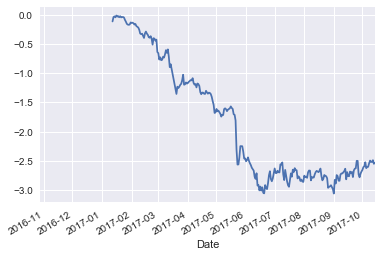

In [9]:
bollinger_strat(zec,20,2)

In [10]:
'''#Set up "daily look back period" and "number of standard deviation" vectors
#For example the first one creates a vector of 20 evenly spaced integer values ranging from 10 to 100
#The second creates a vector of 10 evenly spaced floating point numbers from 1 to 3
windows = np.linspace(10,100,20,dtype=int)
stds = np.linspace(1,3,10)
 
#And iterate through them both, running the strategy function each time
for window in windows:
    for std in stds:
        bollinger_strat(zec,window,std)'''

'#Set up "daily look back period" and "number of standard deviation" vectors\n#For example the first one creates a vector of 20 evenly spaced integer values ranging from 10 to 100\n#The second creates a vector of 10 evenly spaced floating point numbers from 1 to 3\nwindows = np.linspace(10,100,20,dtype=int)\nstds = np.linspace(1,3,10)\n \n#And iterate through them both, running the strategy function each time\nfor window in windows:\n    for std in stds:\n        bollinger_strat(zec,window,std)'

In [11]:
def crypto_ma_opt(crypto, fast = 1):
    
    df = crypto.copy()
    
    df['fast'] = df[['Close']].rolling(fast).mean().shift(1)    
    df['Position'] = None
    
    for row in range(len(df)):
        if (df['Close'] >= df['fast']):
            df['Position'].iloc[row] = 1

        if (df['Close'] <= df['fast']):
            df['Position'].iloc[row] = -1
    
    df['Position'].fillna(method='ffill',inplace=True)
    df['Market Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Strategy Return'] = df['Market Return'] * df['Position']
    df['Strategy Return'].cumsum().plot()


In [12]:
crypto_ma_opt(btc,fast = 10)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
btc['fast'] = btc[['Close']].rolling(10).mean().shift(1)  

In [ ]:
btc['Close'] > btc['fast']